<a href="https://colab.research.google.com/github/Animesh-Guchhait/DEEP-SURVIVAL-PERSONALIZED-TREATMENT-RECOMMENDER-SYSTEM/blob/master/my_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall numpy
!pip install numpy==1.19.0

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.21.6.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-2d23e62b.3.17.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.21.6
     |████████████████████████████████| 14.6 MB 4.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.0

In [ ]:
import numpy as np
import h5py
import pandas as pd

In [ ]:

!pip install imgaug==0.2.5
!pip install deepsurvk

In [ ]:
import numpy as np
import tensorflow as tf


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import deepsurvk
from deepsurvk.datasets import load_rgbsg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/SAML/heart_failure_clinical_records_dataset.csv')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
features=df.columns[:-2]

In [ ]:
# Building training and testing sets #
train_dataset,test_dataset = train_test_split( df, test_size = 0.20,random_state=60)

# Creating the X, T and E input
X_train, X_test = train_dataset[features],test_dataset[features]
T_train, T_test = train_dataset['time'].values, test_dataset['time'].values
E_train, E_test =train_dataset['DEATH_EVENT'].values, test_dataset['DEATH_EVENT'].values

In [ ]:
# Calculate important parameters.
n_patients_train = X_train.shape[0]
n_features = X_train.shape[1]

In [ ]:
n_features,n_patients_train

(11, 239)

In [ ]:
# Standardization
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)



In [ ]:
T_train=pd.DataFrame(T_train)
T_test=pd.DataFrame(T_test)
T_train.columns=['T']
T_test.columns=['T'] 

In [ ]:
params = {'n_layers':2,
          'n_nodes':8,
          'activation':'selu',
          'learning_rate':0.154,
          'decays':5.667e-3,
          'momentum':0.887,
          'l2_reg':6.551,
          'dropout':0.661,
          'optimizer':'nadam'}

In [ ]:
dsk = deepsurvk.DeepSurvK(n_features=n_features, 
                          E=E_train,
                          **params)

In [ ]:
loss = deepsurvk.negative_log_likelihood(E_train)
dsk.compile(loss=loss)


In [ ]:
callbacks = deepsurvk.common_callbacks()

epochs = 1000
history = dsk.fit(X_train, T_train, 
                  batch_size=n_patients_train,
                  epochs=epochs, 
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 337521.0000
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 337866.4062
Epoch 3/1000
1/1 [==============================] - 0s 46ms/step - loss: 244024.7969
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 376390.2188
Epoch 5/1000
1/1 [==============================] - 0s 10ms/step - loss: 275726.2188
Epoch 6/1000
1/1 [==============================] - 0s 11ms/step - loss: 494516.3438
Epoch 7/1000
1/1 [==============================] - 0s 10ms/step - loss: 557228.8125
Epoch 8/1000
1/1 [==============================] - 0s 8ms/step - loss: 332002.0625
Epoch 9/1000
1/1 [==============================] - 0s 9ms/step - loss: 318376.0000
Epoch 10/1000
1/1 [==============================] - 0s 58ms/step - loss: 239721.4219
Epoch 11/1000
1/1 [==============================] - 0s 20ms/step - loss: 349952.2188
Epoch 12/1000
1/1 [==============================] - 0s 13ms/step -

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc6942c8c10>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


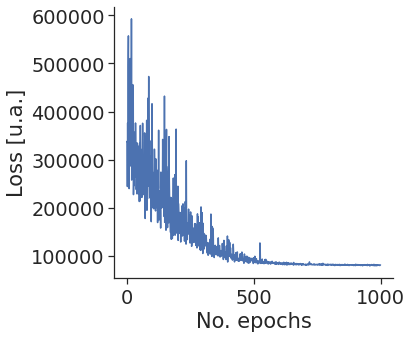

In [ ]:
deepsurvk.plot_loss(history)

In [ ]:
T_pred_train = np.exp(-dsk.predict(X_train))
c_index_train = deepsurvk.concordance_index(T_train, T_pred_train, E_train)
print(f"c-index of training dataset = {c_index_train}")

T_pred_test = np.exp(-dsk.predict(X_test))
c_index_test = deepsurvk.concordance_index(T_test, T_pred_test, E_test)
print(f"c-index of testing dataset = {c_index_test}")

c-index of training dataset = 0.7246927374301676
c-index of testing dataset = 0.7251243781094527


In [ ]:
params = {'epochs':[999],
          'n_layers':[1, 3],
          'n_nodes':[2, 8], 
          'learning_rate':[0.154],
          'decay':[5.667e-3],
          'momentum':[0.887],
          'l2_reg':[6.551],
          'dropout':[0.661],
          'optimizer':['nadam']}

In [ ]:
best_params = deepsurvk.optimize_hp(pd.DataFrame(X_train), pd.DataFrame(T_train), pd.DataFrame(E_train),
                                    mode='grid', 
                                    n_splits=3, 
                                    n_repeats=5, 
                                    verbose=True, 
                                    **params)

print(best_params)

Streaming output truncated to the last 5000 lines.
Epoch 856/999
1/1 [==============================] - 0s 15ms/step - loss: 30610.0723
Epoch 857/999
1/1 [==============================] - 0s 11ms/step - loss: 30743.5156
Epoch 858/999
1/1 [==============================] - 0s 14ms/step - loss: 30792.0352
Epoch 859/999
1/1 [==============================] - 0s 10ms/step - loss: 30750.0059
Epoch 860/999
1/1 [==============================] - 0s 12ms/step - loss: 30692.4434
Epoch 861/999
1/1 [==============================] - 0s 10ms/step - loss: 30718.9102
Epoch 862/999
1/1 [==============================] - 0s 8ms/step - loss: 30722.0898
Epoch 863/999
1/1 [==============================] - 0s 13ms/step - loss: 30732.1523
Epoch 864/999
1/1 [==============================] - 0s 8ms/step - loss: 30735.5371
Epoch 865/999
1/1 [==============================] - 0s 15ms/step - loss: 30712.7227
Epoch 866/999
1/1 [==============================] - 0s 11ms/step - loss: 30715.8477
Epoch 867/999
1/